#### Classification Models

In [1]:
# MNIST dataset
from sklearn.datasets import fetch_openml
mnist = fetch_openml("mnist_784", as_frame=False)
# default is to return as df, but image data within frames doesnt make sense

In [2]:
mnist.DESCR
mnist.data #input data, typically 2D numpy array
mnist.target #labels, usually 1d numpy array

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [3]:
dataset, labels = mnist.data, mnist.target
dataset.shape
# each image is 28x28 pixels, 784 features total

(70000, 784)

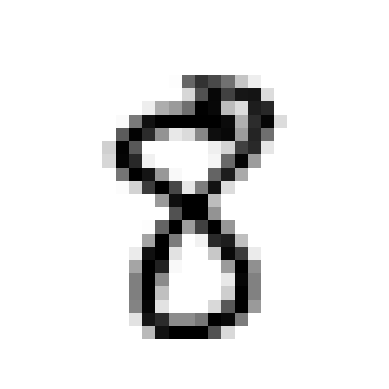

In [4]:
import matplotlib.pyplot as plt
def plotDigit(data):
    plt.imshow(data.reshape(28,28), cmap="binary")
    plt.axis("off")

plotDigit(dataset[46])
plt.show()

In [5]:
labels[46]

'8'

In [6]:
# Mnist dataset is actually already split into train/test

trainData, testData, trainLabels, testLabels = dataset[:60000], dataset[60000:], labels[:60000], labels[60000:]

#### Training A Binary Classifier

In [7]:
# First, lets just do the number 5
trainLabels5 = (trainLabels=="5")
testLabels5 = (testLabels=="5")

# Stochastic Gradient Descent Classifier
# SGD is good for large datasets, deals with training independently, one at a time
from sklearn.linear_model import SGDClassifier
sgd = SGDClassifier(random_state=42)
sgd.fit(trainData, trainLabels5)

SGDClassifier(random_state=42)

In [8]:
sgd.predict([trainData[0]])

array([ True])

## Performance Measures

In [9]:
# Cross Validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd, trainData, trainLabels5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.95035, 0.96035, 0.9604 ])

In [10]:
# comparing this to a dummy classifier
# the dummy just classifies every image as the most common class (non-5)
# this is equivalent to blindly making the statistically most likely guess without
# actually knowing anything about the image
from sklearn.dummy import DummyClassifier
dummy = DummyClassifier()
cross_val_score(dummy, trainData, trainLabels5, cv=3, scoring="accuracy", n_jobs=-1)

array([0.90965, 0.90965, 0.90965])

Accuracy is usually not the best performance metric for classifiers, instead try the Confusion Matrix (CM)

#### Confusion Matrices

In [11]:
# A confusion matrix counts the number of times instances of A are classified as B,
# for all A/B pairs.
# ie. times 0 is counted as 8, 1 is counted as 7, etc

# First step: get a set of predictions so they can be compared to actual targets
from sklearn.model_selection import cross_val_predict
predictedLabels = cross_val_predict(sgd, trainData, trainLabels5, cv=3, n_jobs=-1)

In [12]:
from sklearn.metrics import confusion_matrix
(confusion_matrix(trainLabels5, predictedLabels) / len(trainLabels5)).round(3)
# Vals along diagonal are correct, off diagonal = bad prediction

array([[0.898, 0.011],
       [0.032, 0.059]])

In [13]:
# Precision = true positives / (true positives + false positives)
# Recall = true positives / (true positives + false negatives)

# True Negative = Classified negative, is negative (classified a 6 as not 5)
# True Positive = Classified positive, is positive (classified a 5 as a 5)
# False Negative = Classified negative, is positive (classified a 5 as not a 5)
# False Positive = Classified positive, is negative (classified a 6 as a 5)

In [14]:
from sklearn.metrics import precision_score, recall_score
display(precision_score(trainLabels5, predictedLabels))
recall_score(trainLabels5, predictedLabels)

# Way to read this: 
# Precision num is how often we are right when we say something is 5
# Recall num is how many of the 5s we got right
# We can see that we are missing a lot of 5s

0.8370879772350012

0.6511713705958311

##### F<sub>1</sub> Score

In [15]:
# F1 = 2 x (precision x recall) / (precision + recall) =
# TP / (TP + [{FN+FP} / 2])
# Harmonic mean of precision and recall, more weight to low vals
from sklearn.metrics import f1_score
f1_score(trainLabels5, predictedLabels) 

0.7325171197343847

None of these metrics are inherently better, you need to know what to look for. Making a model to flag inappropriate videos should have high precision, because you don't want any bad videos to slip through. Making a model to find shoplifters should have high recall, because you don't want any shoplifters to get away.

Often, you have to decide between having better or precision or recall. SGDClassifier outputs one number, a "score" of how confident something is a 5, for example. There is a threshold value for how high the score must be to be classified as positive. If you increase the threshold, you get higher precision, but more 5s will be classified as not 5, lowering recall. This goes the other way around too.

In [16]:
sgd.decision_function([trainData[0]]) 

# the first val in the training set is a 5, and our classifier is pretty positive that 
# it is a 5

# you can collect all the decision function values and use your own threshold 

array([2164.22030239])

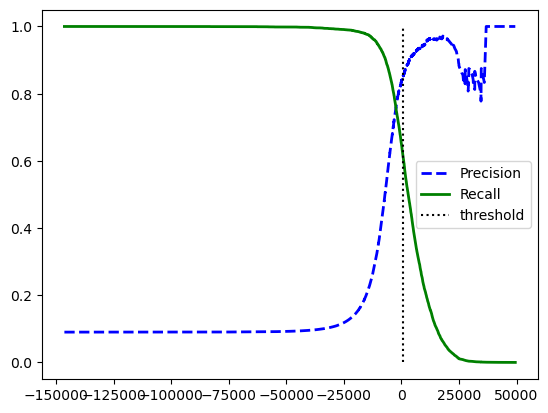

In [ ]:
# How to decide on the threshold? Get decision scores first
scores = cross_val_predict(sgd, trainData, trainLabels5, cv=3, method="decision_function", n_jobs=-1)

#Then, get precision and recall curves
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(trainLabels5,scores)
threshold=0 
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
plt.legend()
plt.show()


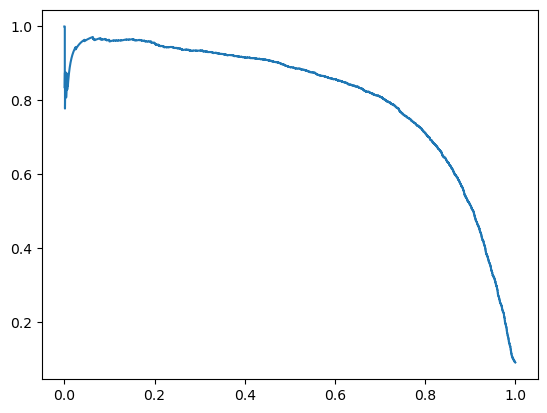

In [ ]:
plt.plot(recalls, precisions)
# around 80% recall, precision falls off a cliff

In [23]:
# find index for 90% precision
idx = (precisions>=.9).argmax()
thresholds[idx]
# now switch to 90% precision prediction
trainLabelsPrecision = (scores > thresholds[idx])
precision_score(trainLabels5, trainLabelsPrecision)

0.9

In [ ]:
# other ways to adjust decision threshold
# FixedThresholdClassifier > wraps binary classifier, set desires threshold manually
# TunedThresholdClassifierCV > uses cross val to find optimal threshold

#### ROC Curve

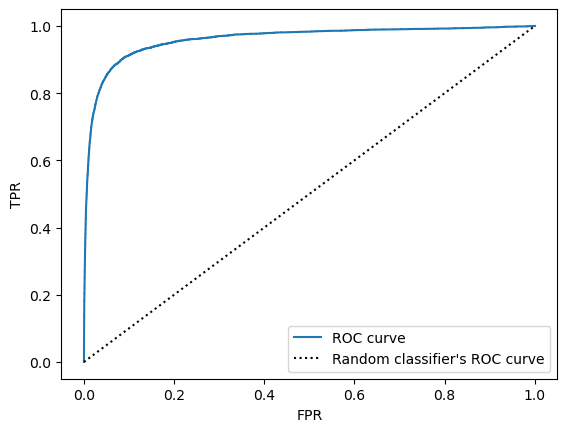

In [28]:
# Receiver Operating Characteristic Curve
# Plots true positive rate (recall) against false positive rate 
# sensitivity = recall
# specificity = true negative rate
# roc = sensitivity vs (1 - specificity)
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(trainLabels5, scores)

plt.plot(fpr, tpr, label="ROC curve")
plt.plot([0, 1], [0, 1], 'k:', label="Random classifier's ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

In [ ]:
# A good way to compare classifiers is ROC AUC (area under curve)
# closer to 1 area under the curve is better
from sklearn.metrics import roc_auc_score
roc_auc_score(trainLabels5, scores)

0.9604938554008616

Generally, prefer precision recall curve to ROC when positive is rare, or when you care more about false positives than false negatives (rare, think medical: better to lie and tell someone they have a disease they don't than lie and say they don't have a disease that they actually do). 

In [ ]:
# creating a randomforestclassifier to compare
from sklearn.ensemble import RandomForestClassifier
forestClf = RandomForestClassifier(random_state=12345)
# no decision function for ran forest, but it has a predict_proba method that returns ESTIMATED class probs
forestProbas = cross_val_predict(forestClf, trainData, trainLabels5, cv=3, method="predict_proba", n_jobs=-1)

# these are estimated probs
# to get closer to real probs, use CalibratedClassifierCV from sklearn.calibration

In [32]:
forestProbas 
#first image is 5 with 91% prob, not 5 with 9% prob

array([[0.09, 0.91],
       [1.  , 0.  ],
       [1.  , 0.  ],
       ...,
       [0.02, 0.98],
       [0.89, 0.11],
       [0.95, 0.05]])

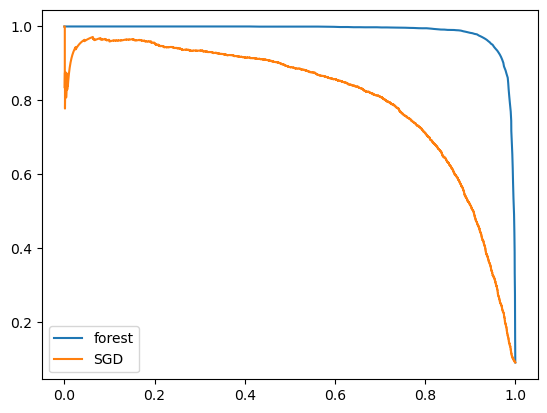

In [36]:
precisionsF, recallsF, thresholdsF = precision_recall_curve(trainLabels5, forestProbas[:,1])
plt.plot(recallsF, precisionsF, label="forest")
plt.plot(recalls,precisions, label="SGD")
plt.legend()
plt.show()
# random forest looks a lot better

In [39]:
display(f1_score(trainLabels5, (forestProbas[:,1]>=0.5)))
roc_auc_score(trainLabels5, forestProbas[:,1])


0.9284105376554695

0.9980985795992121

In [41]:
precision_score(trainLabels5, (forestProbas[:,1]>=0.5))

0.9895615866388309

## Multiclass Classification